## Прогнозирование стоимости автомобиля по характеристикам
У нас есть собранные условной компанией записи о продаже автомобилей и данные авто.ру. На данных с сайта мы тренируем модели, на тестовых данных проверяем результат обучения. Задача - как можно точнее предсказать цену машины.

# Загружаем нужные библиотеки

In [1]:
import requests as r
from bs4 import BeautifulSoup
import json
import time

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

import lightgbm as lgb

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


# Необходимые функции

In [4]:
'''Функция расчета точности модели (замечание: ее стоило бы называть "...неточности", чтобы не возникало вопросов)'''


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
'''Простенькая функция для краткого описания признака'''


def sign_study(column):
    print(df[column].value_counts())
    print(df[column].isna().sum())

In [6]:
'''Функция для перевода числовых значений в категориальные'''


def sign_to_cat(column):
    if column <= perc25:
        column = '0'
        return column
    if perc25 < column <= perc50:
        column = '1'
        return column
    if perc50 < column <= perc75:
        column = '2'
        return column
    if column > perc75:
        column = '3'
        return column

# Setup

In [7]:
VERSION = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

# Data

In [8]:
!ls '../input'

autoru-18-07-2021	 parsing-all-moscow-auto-ru-09-09-2020
autoru-cars-dataset	 sf-dst-car-price-prediction
autoru-parsed-0603-1304


**Подключаем датасеты: тренировочный и тестовый.**

К сожалению, времени на свой парсинг и корректное применение скачанного чужим не хватило, поэтому взяла готовый из самых свежих.

In [9]:
train = pd.read_csv('../input/autoru-cars-dataset/autoru_cars_dataset.csv')
# train = pd.read_csv('../input/autoru-18-07-2021/all_auto_ru.csv') спарсила данные, добилась отличных показателей на валидационных данных,
# но очень плохо выступила в программе (https://www.kaggle.com/lenkavinogradova/proba-car-selection-2a)
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,9,11,14,16,19,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Первичное исследование train**

In [10]:
train.head(5)

,Unnamed: 0,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,acceleration,fuel_rate
0,0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,синий,{'id': '0'},Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,2.0,235.0,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209286...,85452.0,2014.0,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0d AT (235 л.с.) 4WD,5.0,1.604647e+12,RUR,2016.0,1101191623-464cf4be,"{'id': '20228874', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2799000.0,7.8,5.7
1,1,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s80/11013...,чёрный,{'id': '0'},При покупке автомобиля до 15 ноября \n► Выгод...,2.5,249.0,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216441...,116410.0,2009.0,"{'code': 'S80', 'name': 'S80', 'ru_name': 'S80...",S80,2.5 AT (249 л.с.),4.0,1.604660e+12,RUR,2013.0,1101345022-3e0e4f8c,"{'id': '7974165', 'name': 'II Рестайлинг', 'ru...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1277000.0,7.0,8.6
2,3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1100...,чёрный,{'id': '0'},Автодилер года 2020\n\nПобедитель в номинации ...,2.4,190.0,"{'cruise-control': True, 'engine-proof': True,...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209157...,83657.0,2013.0,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (190 л.с.) 4WD,5.0,1.604656e+12,RUR,2016.0,1100336634-a6643416,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1869000.0,9.7,5.7
3,4,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,чёрный,{'id': '0'},Объявление №690\n\nАвтомобиль в отличном состо...,2.4,170.0,"{'engine-proof': True, 'cruise-control': True,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/210185...,118000.0,2004.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,2.4 AT (170 л.с.),4.0,1.604639e+12,RUR,2006.0,1101497967-8c590a51,"{'id': '2309989', 'name': 'I Рестайлинг', 'ru_...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,369000.0,9.6,9.5
4,5,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,белый,{'id': '0'},"Авто в отличном состоянии, вложений не требует...",1.6,150.0,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/200015...,121421.0,2010.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,1.6 AMT (150 л.с.),4.0,1.604699e+12,RUR,2012.0,1101427740-01c03c86,"{'id': '6478325', 'name': 'II', 'ru_name': '2'...",SEDAN ROBOT 1.6,роботизированная,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,650000.0,10.2,6.8


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108209 entries, 0 to 108208
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            108209 non-null  int64  
 1   bodyType              108209 non-null  object 
 2   brand                 108209 non-null  object 
 3   car_url               108209 non-null  object 
 4   color                 108209 non-null  object 
 5   complectation_dict    20165 non-null   object 
 6   description           104798 non-null  object 
 7   engineDisplacement    108209 non-null  float64
 8   enginePower           108209 non-null  float64
 9   equipment_dict        20165 non-null   object 
 10  fuelType              108209 non-null  object 
 11  image                 20165 non-null   object 
 12  mileage               107655 non-null  float64
 13  modelDate             108209 non-null  float64
 14  model_info            20165 non-null   object 
 15  

In [12]:
# Удаляем строки с нулевой ценой
train = train.dropna(axis=0, subset=['price'])

In [13]:
train['price']

0         2799000.0
1         1277000.0
2         1869000.0
3          369000.0
4          650000.0
            ...    
108204    1605000.0
108205    1250000.0
108206    5500000.0
108207    3200000.0
108208     880000.0
Name: price, Length: 108209, dtype: float64

In [14]:
len(train) - len(train.drop_duplicates())

0

In [15]:
# train = train.drop_duplicates()

In [16]:
# Чтобы потом проверить, правильно ли мы разделили датасет, надо посмотреть на его размер.
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))

Размерность тренировочного датасета:  (108209, 36)


,Unnamed: 0,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,acceleration,fuel_rate
0,0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,синий,{'id': '0'},Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,2.0,235.0,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209286...,85452.0,2014.0,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0d AT (235 л.с.) 4WD,5.0,1.604647e+12,RUR,2016.0,1101191623-464cf4be,"{'id': '20228874', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2799000.0,7.8,5.7
1,1,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s80/11013...,чёрный,{'id': '0'},При покупке автомобиля до 15 ноября \n► Выгод...,2.5,249.0,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216441...,116410.0,2009.0,"{'code': 'S80', 'name': 'S80', 'ru_name': 'S80...",S80,2.5 AT (249 л.с.),4.0,1.604660e+12,RUR,2013.0,1101345022-3e0e4f8c,"{'id': '7974165', 'name': 'II Рестайлинг', 'ru...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1277000.0,7.0,8.6
2,3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1100...,чёрный,{'id': '0'},Автодилер года 2020\n\nПобедитель в номинации ...,2.4,190.0,"{'cruise-control': True, 'engine-proof': True,...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209157...,83657.0,2013.0,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (190 л.с.) 4WD,5.0,1.604656e+12,RUR,2016.0,1100336634-a6643416,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1869000.0,9.7,5.7
3,4,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,чёрный,{'id': '0'},Объявление №690\n\nАвтомобиль в отличном состо...,2.4,170.0,"{'engine-proof': True, 'cruise-control': True,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/210185...,118000.0,2004.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,2.4 AT (170 л.с.),4.0,1.604639e+12,RUR,2006.0,1101497967-8c590a51,"{'id': '2309989', 'name': 'I Рестайлинг', 'ru_...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,369000.0,9.6,9.5
4,5,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,белый,{'id': '0'},"Авто в отличном состоянии, вложений не требует...",1.6,150.0,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/200015...,121421.0,2010.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,1.6 AMT (150 л.с.),4.0,1.604699e+12,RUR,2012.0,1101427740-01c03c86,"{'id': '6478325', 'name': 'II', 'ru_name': '2'...",SEDAN ROBOT 1.6,роботизированная,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,650000.0,10.2,6.8


**Первичное исследование test**

In [17]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [19]:
# Обнуляем цену в тестовом датасете.
test['price'] = 0

In [20]:
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тестового датасета:  (34686, 33)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0


**Сравнение train и test**

In [21]:
#  Взяла у участников соревнования функцию по сравнению датасетов
def check_df_before_merg(d_df1, d_df2):

    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_dict['# unique_train'] = d_df1.nunique().values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)

    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_dict2['# unique_test'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)

    temp_insert = pd.DataFrame(columns=['< - >'])

    temp_df = pd.concat([temp_df1, temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace=True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3 = pd.DataFrame(temp_df)
    temp_list = []
    temp_list2 = []
    temp_list3 = []
    temp_list4 = []
    temp_list5 = []

    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(
                str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)
        if temp_df3['# unique_test'][i] > 0 and temp_df3['# unique_train'][i]/temp_df3['# unique_test'][i] > 2:
            temp_list5.append(i)

    temp_dict3['index'] = temp_list4
    temp_dict3['feature_train'] = temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['feature_test'] = temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index', inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(
        f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)

In [22]:
check_df_before_merg(train, test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,Unnamed: 0,int64,6,108209,| - |,NaN,NaN,NaN,NaN
1,bodyType,object,седан,23,| - |,bodyType,object,лифтбек,24.0
2,brand,object,VOLVO,12,| - |,brand,object,SKODA,12.0
3,car_url,object,https://auto.ru/cars/used/sale/volvo/s80/11012...,106488,| - |,car_url,object,https://auto.ru/cars/used/sale/skoda/octavia_r...,34686.0
4,color,object,синий,16,| - |,color,object,серый,16.0
5,complectation_dict,object,{'id': '0'},1626,| - |,complectation_dict,object,"{""id"":""5011515"",""name"":""RS"",""available_options...",2364.0
6,description,object,Внимание! Только для клиентов AVILON Автомобил...,95236,| - |,description,object,Продаю свой автомобиль! Автомобиль полностью и...,31732.0
7,engineDisplacement,float64,2.5,54,| - |,engineDisplacement,object,2.0 LTR,55.0
8,enginePower,float64,200,317,| - |,enginePower,object,200 N12,315.0
9,equipment_dict,object,"{'engine-proof': True, 'airbag-driver': True, ...",14445,| - |,equipment_dict,object,"{""cruise-control"":true,""tinted-glass"":true,""es...",23705.0


Резюме:
 1. Не совпали типы в:= 12 столбцах

2. Уникальные значения различаются в:= 5 столбцах [3, 6, 12, 18, 33]


,feature_train,не совпадают типы,feature_test
index,,,
0,Unnamed: 0,int64 != nan,NaN
7,engineDisplacement,float64 != object,engineDisplacement
8,enginePower,float64 != object,enginePower
12,mileage,float64 != int64,mileage
13,modelDate,float64 != int64,modelDate
17,numberOfDoors,float64 != int64,numberOfDoors
18,parsing_unixtime,float64 != int64,parsing_unixtime
20,productionDate,float64 != int64,productionDate
21,sell_id,object != int64,sell_id


Изучим признаки, которые у нас есть, более предметно. 

**Выясним, есть ли у нас разница между колонками в тесте и в трейне.**

In [23]:
test_cols = test.columns
len(test_cols)

33

In [24]:
train_cols = train.columns
len(train_cols)

36

In [25]:
set(train_cols) - set(test_cols)

{'Unnamed: 0', 'acceleration', 'fuel_rate'}

Выясняется, что часть колонок не совпадает. В некоторых из них, как мы видим по предыдущим проверкам, информация слишком сложна для обработки, а некоторые содержат только одно значение. 

Для работы создадим первичный список колонок, который впоследствии будем дополнительно редактировать на объединенном датасете.

In [26]:
cols = ['sell_id', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
        'name', 'model_name', 'numberOfDoors', 'productionDate',
        'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement',
        'enginePower', 'description', 'mileage', 'Привод',
        'Руль', 'Владельцы', 'ПТС', 'Таможня', 'Владение',
        'Состояние', 'price', 'train']

# Объединение датасета

In [27]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1  # помечаем тренировочные
test['train'] = 0  # помечаем тестовые

# оставляем датасет для последующего сравнений и делаем копию для манипуляций
cars = pd.concat([train, test], ignore_index=True)
df = cars.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142895 entries, 0 to 142894
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            108209 non-null  float64
 1   bodyType              142895 non-null  object 
 2   brand                 142895 non-null  object 
 3   car_url               142895 non-null  object 
 4   color                 142895 non-null  object 
 5   complectation_dict    26583 non-null   object 
 6   description           139484 non-null  object 
 7   engineDisplacement    142895 non-null  object 
 8   enginePower           142895 non-null  object 
 9   equipment_dict        44855 non-null   object 
 10  fuelType              142895 non-null  object 
 11  image                 54851 non-null   object 
 12  mileage               142341 non-null  float64
 13  modelDate             142895 non-null  float64
 14  model_info            54851 non-null   object 
 15  

In [28]:
df.head()

,Unnamed: 0,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,acceleration,fuel_rate,train
0,0.0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,синий,{'id': '0'},Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,2,235,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209286...,85452.0,2014.0,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0d AT (235 л.с.) 4WD,5.0,1.604647e+12,RUR,2016.0,1101191623-464cf4be,"{'id': '20228874', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2799000.0,7.8,5.7,1
1,1.0,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s80/11013...,чёрный,{'id': '0'},При покупке автомобиля до 15 ноября \n► Выгод...,2.5,249,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216441...,116410.0,2009.0,"{'code': 'S80', 'name': 'S80', 'ru_name': 'S80...",S80,2.5 AT (249 л.с.),4.0,1.604660e+12,RUR,2013.0,1101345022-3e0e4f8c,"{'id': '7974165', 'name': 'II Рестайлинг', 'ru...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1277000.0,7.0,8.6,1
2,3.0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1100...,чёрный,{'id': '0'},Автодилер года 2020\n\nПобедитель в номинации ...,2.4,190,"{'cruise-control': True, 'engine-proof': True,...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209157...,83657.0,2013.0,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (190 л.с.) 4WD,5.0,1.604656e+12,RUR,2016.0,1100336634-a6643416,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1869000.0,9.7,5.7,1
3,4.0,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,чёрный,{'id': '0'},Объявление №690\n\nАвтомобиль в отличном состо...,2.4,170,"{'engine-proof': True, 'cruise-control': True,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/210185...,118000.0,2004.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,2.4 AT (170 л.с.),4.0,1.604639e+12,RUR,2006.0,1101497967-8c590a51,"{'id': '2309989', 'name': 'I Рестайлинг', 'ru_...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,369000.0,9.6,9.5,1
4,5.0,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,белый,{'id': '0'},"Авто в отличном состоянии, вложений не требует...",1.6,150,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/200015...,121421.0,2010.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,1.6 AMT (150 л.с.),4.0,1.604699e+12,RUR,2012.0,1101427740-01c03c86,"{'id': '6478325', 'name': 'II', 'ru_name': '2'...",SEDAN ROBOT 1.6,роботизированная,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,650000.0,10.2,6.8,1


In [29]:
df = df[cols]

In [30]:
# Приведем колонки к более аккуратным названиям:
df.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_volume',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'doors',
                   'productionDate': 'production_date',
                   'vehicleConfiguration': 'vehicle_configuration',
                   'vehicleTransmission': 'transmission',
                   'Владельцы': 'owners_qty',
                   'Владение': 'ownership_time',
                   'ПТС': 'licence',
                   'Привод': 'type_of_drive',
                   'Руль': 'steering_wheel',
                   'Таможня': 'customs',
                   'Состояние': 'state',
                   'Price': 'price'}, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142895 entries, 0 to 142894
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sell_id                54851 non-null   object 
 1   body_type              142895 non-null  object 
 2   brand                  142895 non-null  object 
 3   color                  142895 non-null  object 
 4   fuel_type              142895 non-null  object 
 5   model_date             142895 non-null  float64
 6   name                   54851 non-null   object 
 7   model_name             142895 non-null  object 
 8   doors                  142895 non-null  float64
 9   production_date        142895 non-null  float64
 10  vehicle_configuration  54851 non-null   object 
 11  transmission           142895 non-null  object 
 12  engine_volume          142895 non-null  object 
 13  engine_power           142895 non-null  object 
 14  description            139484 non-nu

делаем быстрый EDA с помощью pandas_profiling. Полные результаты [здесь](https://www.kaggle.com/lenkavinogradova/pandas-profiling-for-car-selection).

Краткое содержание:

В ряде признаков много пропущенных значений (name, vehicle_configuration и ownership_time).
Несколько признаков сильно коррелируют между собой (model_date и production_date).
Некоторые признаки не поддерживаются, и их надо будет обработать.
А customs содержит только одно значение, и его, похоже, надо будет удалять.

Все эти знания мы применим при обработке признаков.

## Data Preprocessing

In [32]:
# Исследуем на пропущенные значения:
df.isna().sum()

sell_id                  88044
body_type                    0
brand                        0
color                        0
fuel_type                    0
model_date                   0
name                     88044
model_name                   0
doors                        0
production_date              0
vehicle_configuration    88044
transmission                 0
engine_volume                0
engine_power                 0
description               3411
mileage                    554
type_of_drive                0
steering_wheel               0
owners_qty                   0
licence                      1
customs                      0
ownership_time           99384
state                        0
price                        0
train                        0
dtype: int64

**Зададим группы признаков для массовой обработки**

In [33]:
# числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

# Исследуем признаки

**Целевая переменная - price**

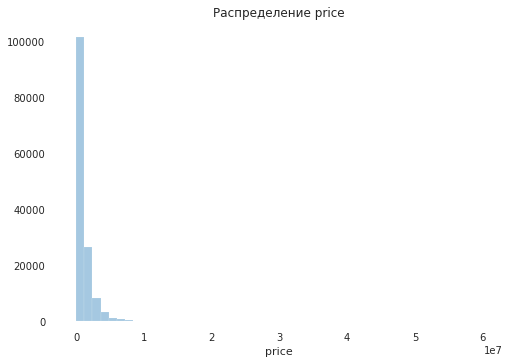

In [34]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(df.price, kde=False)

Распределение сильно смещено влево, поэтому, скорее всего, при обучении модели признак надо будет логарифмировать.

**Тип кузова**

In [35]:
sign_study('body_type')

седан                      53812
внедорожник 5 дв.          52748
лифтбек                     9661
хэтчбек 5 дв.               9570
универсал 5 дв.             5132
минивэн                     2982
купе                        2555
компактвэн                  1822
хэтчбек 3 дв.               1662
пикап двойная кабина        1204
купе-хардтоп                 468
фургон                       457
родстер                      252
кабриолет                    241
внедорожник 3 дв.            227
пикап полуторная кабина       21
микровэн                      19
седан-хардтоп                 16
пикап одинарная кабина        15
седан 2 дв.                   10
лимузин                        9
внедорожник открытый           7
тарга                          4
фастбек                        1
Name: body_type, dtype: int64
0


In [36]:
# Приведем названия типов к единообразию, выбрав только первые элементы:
df['body_type'] = df['body_type'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
df['body_type'] = df.body_type.apply(lambda x: x.split(' ')[0].lower())

In [37]:
sign_study('body_type')

седан            53822
внедорожник      52982
хэтчбек          11232
лифтбек           9661
универсал         5132
минивэн           2982
купе              2555
компактвэн        1822
пикап             1240
купе-хардтоп       468
фургон             457
родстер            252
кабриолет          241
микровэн            19
седан-хардтоп       16
лимузин              9
тарга                4
фастбек              1
Name: body_type, dtype: int64
0


Посмотрим на распределение признака:

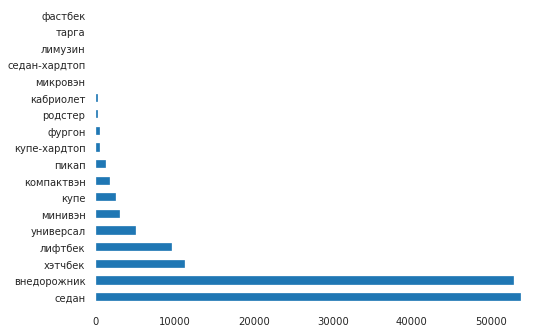

In [38]:
df.body_type.value_counts().plot.barh()

Больше всего продается седанов и внедорожников. В принципе, можно было бы добавить бинарный признак на его основе "Седан или внедорожник".

Пока добавим основной признак в список категориальных.

In [39]:
cat_cols.append('body_type')

**Название бренда**

In [40]:
sign_study('brand')

VOLKSWAGEN    19948
TOYOTA        17873
NISSAN        16101
BMW           15267
MERCEDES      14527
AUDI          13838
SKODA         12313
MITSUBISHI    11979
HONDA          5951
VOLVO          5767
LEXUS          5751
INFINITI       3580
Name: brand, dtype: int64
0


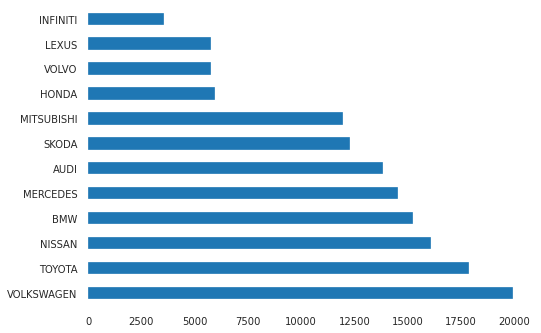

In [41]:
df.brand.value_counts().plot.barh()

Чаще всего продают фольксвагены - народную марку. 

Этот признак категориальный и не требует дополнительной обработки.

In [42]:
cat_cols.append('brand')

**Цвет**

In [43]:
sign_study('color')

чёрный         43602
белый          29351
серый          19810
серебристый    14332
синий          12817
красный         6511
коричневый      5042
зелёный         3408
бежевый         2076
голубой         1670
золотистый      1420
фиолетовый       979
пурпурный        737
жёлтый           643
оранжевый        457
розовый           40
Name: color, dtype: int64
0


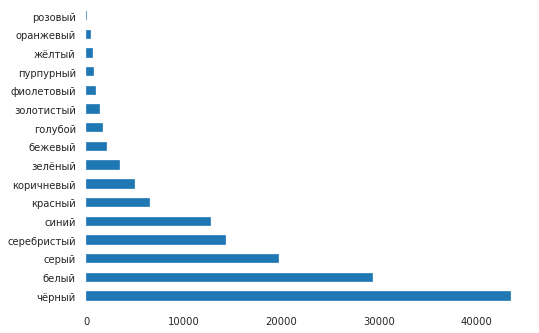

In [44]:
df.color.value_counts().plot.barh()

Самые популярные в продаже машины - черные и белые. Создадим новый бинарный признак "популярный цвет" и добавим его в список бинарных. Основной признак - категориальный.

In [45]:
# Добавим в словарь самые популярные цвета
color_list = ['чёрный', 'белый', 'серый', 'серебристый', 'синий']

#  Новый признак: популярный цвет - 1, остальные - 0
df['pop_color'] = df.color.apply(lambda x: 1 if x in color_list else 0)

In [46]:
cat_cols.append('color')
bin_cols.append('pop_color')

**Описание**

Описание - это сложный признак, который, в принципе, можно дополнительно парсить и анализировать средствами python. Попробуем сделать из него несколько признаков простым поиском слов. Но сначала сделаем самый примитивный числовой признак - "длина описания".

In [47]:
# новый числовой признак
df['description_len'] = df.description.apply(lambda x: len(str(x)))

In [48]:
'''Также из этого описания можно в некоторых случаях понять, имеем ли мы дело с салоном или с продавцом-частником. Сгенерируем признаки для этого'''

df['description'] = df['description'].map(lambda x: str(x).lower())

df['owner'] = df['description'].apply(
    lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x) < 200 else 0)
df['showroom'] = df['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                         or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x
                                         or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(df['owner'].value_counts())
display(df['showroom'].value_counts())

0    73434
1    69461
Name: owner, dtype: int64

0    91852
1    51043
Name: showroom, dtype: int64

Несколько новых бинарных признаков, дающих представление о комплектации автомобиля.

In [49]:
df['new'] = df.description.apply(lambda x: 1 if 'нов' in x else 0)
df['tires'] = df.description.apply(
    lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
df['heating'] = df.description.apply(
    lambda x: 1 if 'подогрев сидений' in x else 0)
df['central_lock'] = df.description.apply(
    lambda x: 1 if 'центральный замок' in x else 0)
df['computer'] = df.description.apply(
    lambda x: 1 if 'бортовой компьютер' in x else 0)
df['airbag'] = df.description.apply(
    lambda x: 1 if 'подушки безопасности' in x else 0)
df['power_steering'] = df.description.apply(
    lambda x: 1 if 'усилитель руля' in x else 0)
df['cruise_control'] = df.description.apply(
    lambda x: 1 if 'круиз-контроль' in x else 0)
df['parktronic'] = df.description.apply(
    lambda x: 1 if 'парктроник' in x else 0)
df['child_car_seat'] = df.description.apply(
    lambda x: 1 if 'крепления детских автокресел' in x else 0)

In [50]:
# Теперь признак "Описание" нам не нужен.
df = df.drop('description', axis=1)

In [51]:
df['description_len'].isna().sum()

0

In [52]:
num_cols.append('description_len')

In [53]:
bin_cols = bin_cols + ['owner', 'showroom', 'new', 'tires', 'heating', 'central_lock',
                       'computer', 'airbag', 'power_steering', 'cruise_control', 'parktronic', 'child_car_seat']

**Вид топлива**

Простой категориальный признак, не требующий обработки.

In [54]:
sign_study('fuel_type')

бензин     117090
дизель      23016
гибрид       1508
газ          1226
электро        55
Name: fuel_type, dtype: int64
0


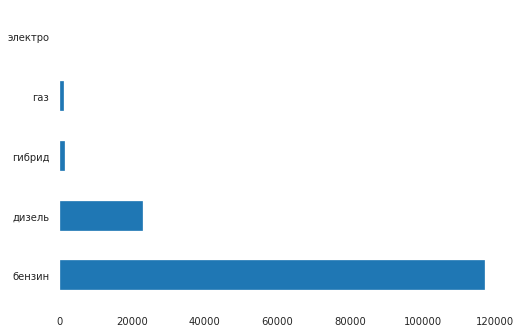

In [55]:
df.fuel_type.value_counts().plot.barh()

In [56]:
cat_cols.append('fuel_type')

**Объем двигателя**

А вот с этим признаком пришлось повозиться. Посмотрим на имеющиеся значения до обработки:

In [57]:
df.engine_volume.unique()

array([2.0, 2.5, 2.4, 1.6, 3.0, 1.2, 1.8, 4.0, 3.2, 1.4, 2.8, 3.5, 2.3,
       1.5, 1.9, 3.6, 1.3, 5.7, 4.2, 4.4, 5.0, 4.9, 5.6, 2.7, 3.1, 3.7,
       5.9, 2.6, 3.3, 3.4, 4.7, 4.5, 4.8, 0.6, 4.1, 6.0, 4.6, 6.3, 2.9,
       2.2, 3.8, 1.1, 5.2, 4.3, 0.7, 1.7, 1.0, 2.1, 6.2, 5.5, 5.4, 6.6,
       5.8, 3.9, '1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR',
       '1.3 LTR', '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR',
       '1.1 LTR', '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR',
       '2.7 LTR', '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR',
       '6.3 LTR', '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR',
       '5.0 LTR', '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR',
       '1.7 LTR', '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR',
       '4.9 LTR', '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR',
       '4.5 LTR', '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR',
       '5.3 LTR', '5.7 LTR'], dtype=object)

In [58]:
sign_study('engine_volume')

2.0        23761
1.6        17253
1.8        10540
3.0        10247
2.0 LTR     7391
           ...  
3.9            5
4.9 LTR        4
1.1 LTR        4
3.9 LTR        1
5.3 LTR        1
Name: engine_volume, Length: 109, dtype: int64
0


In [59]:
# Значения надо почистить, для этого преобразуем их в строки:    
df['engine_volume'] = df['engine_volume'].astype(str)

In [60]:
# Извлечём из признака только числовые данные (объём двигателя в литрах) с помощью regex:
df['engine_volume'] = df['engine_volume'].str.extract(
    '(\d.\d)', expand=False).str.strip()

In [61]:
df['engine_volume'].value_counts()

2.0    31152
1.6    22226
3.0    14162
1.8    13889
2.5     9800
1.4     7907
2.4     6867
3.5     6435
1.5     3637
1.2     2516
4.5     1728
2.8     1711
1.3     1629
3.2     1328
4.4     1209
4.0     1122
2.3     1082
4.7     1056
2.2     1030
3.7      946
1.9      932
5.5      922
3.6      894
2.1      857
2.7      837
5.7      798
5.6      735
4.2      710
4.6      693
5.0      603
2.9      539
2.6      313
4.8      294
1.0      285
3.1      248
1.7      224
3.3      220
3.8      210
0.7      209
4.3      161
6.0      153
4.1      134
6.2      100
5.4       89
3.4       86
5.2       35
5.9       28
6.3       22
5.8       20
1.1       16
6.6       15
4.9       12
0.6        7
3.9        6
5.3        1
Name: engine_volume, dtype: int64

После обработки у нас появились пропуски, но немного. 

In [62]:
df['engine_volume'].isna().sum()

55

Заполним их наиболее часто встречающимся значением.

In [63]:
df['engine_volume'] = df['engine_volume'].fillna(df['engine_volume'].mode())

После нескольких проб выяснилось, что лучше бы перевести этот признак в категориальный и не сохранять числовые значения. Так и поступим.

In [64]:
# Разобьем значения по категориям:
df["engine_volume"] = df["engine_volume"].astype('float').apply(lambda x: 4 if x >= 4 else
                                                                3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
df.engine_volume.value_counts()

2    54188
1    53261
3    24535
4    10640
0      271
Name: engine_volume, dtype: int64

In [65]:
cat_cols.append('engine_volume')

**Мощность двигателя**

Числовой признак, требующий обработки: тип данных смешанный.

In [66]:
sign_study('engine_power')

150.0      6456
249.0      5909
110.0      3922
105.0      3220
102.0      2912
           ... 
630 N12       1
431 N12       1
196.0         1
430 N12       1
42.0          1
Name: engine_power, Length: 632, dtype: int64
0


In [67]:
df['engine_power'] = df['engine_power'].astype(
    str).apply(lambda x: x.split()[0])
df['engine_power'] = df['engine_power'].astype(float)

In [68]:
sign_study('engine_power')

150.0    8155
249.0    7617
110.0    4961
105.0    4175
170.0    3855
         ... 
127.0       1
30.0        1
164.0       1
537.0       1
226.0       1
Name: engine_power, Length: 336, dtype: int64
0


In [69]:
num_cols.append('engine_power')

**Трансмиссия**

Простой категориальный признак. Обработки не требуется.

In [70]:
sign_study('transmission')

автоматическая      75570
механическая        33870
вариатор            17169
роботизированная    16286
Name: transmission, dtype: int64
0


In [71]:
cat_cols.append('transmission')

**Пробег**

In [72]:
sign_study('mileage')

200000.0    1946
300000.0    1760
250000.0    1500
150000.0    1481
180000.0    1369
            ... 
86913.0        1
114803.0       1
63249.0        1
126497.0       1
98302.0        1
Name: mileage, Length: 35190, dtype: int64
554


На случай, если где-то у нас есть вариант, в котором к числу добавлено обозначение "км" (судя по EDA, такого нет, но береженого бог бережет), можем почистить так:

In [73]:
df['mileage'] = df['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [74]:
df['mileage'] = df['mileage'].astype(float)

Пропущенные значения заполним средним и округлим.

In [75]:
df['mileage'] = df['mileage'].fillna(df['mileage'].mean())

In [76]:
df['mileage'] = df['mileage'].apply(lambda x: round(x))

In [77]:
sign_study('mileage')

200000    1946
300000    1760
250000    1500
150000    1481
180000    1369
          ... 
80868        1
97260        1
59634        1
115707       1
4094         1
Name: mileage, Length: 35191, dtype: int64
0


In [78]:
num_cols.append('mileage')

**Привод**

Простой категориальный признак.

In [79]:
sign_study('type_of_drive')

передний    68234
полный      59539
задний      15122
Name: type_of_drive, dtype: int64
0


In [80]:
cat_cols.append('type_of_drive')

**Дата выпуска модели и дата выпуска конкретной машины**

In [81]:
sign_study('model_date')


2013.0    10051
2010.0     9868
2014.0     9290
2012.0     9060
2011.0     8930
          ...  
1957.0        1
1960.0        1
1963.0        1
1973.0        1
1904.0        1
Name: model_date, Length: 67, dtype: int64
0


In [82]:
sign_study('production_date')

2012.0    10967
2013.0    10150
2011.0     9796
2008.0     9762
2014.0     9381
          ...  
1950.0        1
1963.0        1
1968.0        1
1974.0        1
1904.0        1
Name: production_date, Length: 70, dtype: int64
0


In [83]:
df['model_date'] = df['model_date'].astype(int)

In [84]:
df['production_date'] = df['production_date'].astype(int)

In [85]:
# создадим новые признаки на основе существующих: количество лет производства и возраст модели
df['prod_age'] = 2021 - df.production_date
df['model_age'] = 2021 - df.model_date

In [86]:
# определим эти признаки в числовые данные
num_cols = num_cols + ['production_date',
                       'model_date', 'model_age', 'prod_age']

**Название модели**

Добавим этот список в категориальные - это существенно улучшает обучение модели

In [87]:
sign_study('model_name')

OCTAVIA            5831
POLO               3791
CAMRY              3775
PASSAT             3598
5ER                3468
                   ... 
326                   1
02                    1
MASTER_ACE_SURF       1
BEAT                  1
MEGA_CRUISER          1
Name: model_name, Length: 611, dtype: int64
0


In [88]:
cat_cols.append('model_name')

**Количество владельцев**

In [89]:
sign_study('owners_qty')

3 или более    67413
1 владелец     40017
2 владельца    35464
Неизвестно         1
Name: owners_qty, dtype: int64
0


Обработаем данные, чтобы получить числа, и добавим признак в категориальные.

In [90]:
df['owners_qty'] = df['owners_qty'].str.extract(
    '(\d)', expand=False).str.strip()

In [91]:
sign_study('owners_qty')

3    67413
1    40017
2    35464
Name: owners_qty, dtype: int64
1


In [92]:
cat_cols.append('owners_qty')

**ПТС**

Простой бинарный признак с одним пропуском. Заполним его наиболее часто встречающимся значением.

In [93]:
sign_study('licence')

Оригинал    121324
Дубликат     21570
Name: licence, dtype: int64
1


In [94]:
df['licence'] = df['licence'].fillna('Оригинал')

In [95]:
bin_cols.append('licence')

**Руль**

Простой бинарный признак.

In [96]:
sign_study('steering_wheel')

Левый     135664
Правый      7231
Name: steering_wheel, dtype: int64
0


In [97]:
bin_cols.append('steering_wheel')

**vehicleConfiguration**

В принципе, этот признак содержит в себе то, что уже есть в других, но почему-то его простое удаление сильно ухудшило работу модели. Оставляем и обрабатываем:

In [98]:
sign_study('vehicle_configuration')

ALLROAD_5_DOORS AUTOMATIC 3.0     3686
ALLROAD_5_DOORS VARIATOR 2.0      2328
ALLROAD_5_DOORS AUTOMATIC 2.0     2264
SEDAN MECHANICAL 1.6              2125
SEDAN AUTOMATIC 2.0               2009
                                  ... 
ALLROAD_5_DOORS MECHANICAL 2.3       1
PICKUP_TWO AUTOMATIC 3.2             1
WAGON_5_DOORS AUTOMATIC 5.5          1
ALLROAD_3_DOORS MECHANICAL 4.5       1
MICROVAN AUTOMATIC 1.3               1
Name: vehicle_configuration, Length: 646, dtype: int64
88044


In [99]:
df['vehicle_configuration'] = df['vehicle_configuration'].astype(
    str).apply(lambda x: x if len(x) == 1 else x.split())

In [100]:
df['vehicle_configuration'] = df['vehicle_configuration'].apply(
    lambda x: x[0].lower() if len(x) == 1 else x[1].lower())

In [101]:
sign_study('vehicle_configuration')

nan           88044
automatic     29064
mechanical    12002
robot          6978
variator       6807
Name: vehicle_configuration, dtype: int64
0


Пропуски автоматически заполнены значением 'nan' - для модели это хорошо. Но мы можем попробовать заменить их следующим по частоте после 'nan' значением.

In [102]:
# df['vehicle_configuration'] = df['vehicle_configuration'].apply(lambda x: 'automatic' if x == 'nan' else x)

Однако выяснилось, что при такой замене значение модели сильно ухудшается. Поэтому сделаем вывод, что отсутствие значения в этом случае является признаком. Еще один вариант - сделать из него бинарный признак (0 для nan, 1 для остального). Это никак не меняет результат внутри ноутбука, но слегка ухудшает его в соревновании.

In [103]:
# df['vehicle_configuration'] = df['vehicle_configuration'].apply(lambda x: 0 if x == 'nan' else 1)

In [104]:
sign_study('vehicle_configuration')

nan           88044
automatic     29064
mechanical    12002
robot          6978
variator       6807
Name: vehicle_configuration, dtype: int64
0


In [105]:
cat_cols.append('vehicle_configuration')
# bin_cols.append('vehicle_configuration')

**Количество дверей**

In [106]:
sign_study('doors')

5.0    80049
4.0    57129
2.0     3636
3.0     2080
0.0        1
Name: doors, dtype: int64
0


Бывают ли автомобили без дверей? Проверим, что это за удивительный выброс...

In [107]:
df[df['doors'] == 0]

,sell_id,body_type,brand,color,fuel_type,model_date,name,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,customs,ownership_time,state,price,train,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age
125153,1093802104,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),SIMPLEX,0.0,1904,mechanical,механическая,4,32.0,48000,задний,Правый,1,Оригинал,Растаможен,6 лет и 8 месяцев,Не требует ремонта,0.0,0,1,785,0,0,1,1,0,0,0,0,0,0,0,0,117,117


Мы посмотрели на модель мерседеса выпуска 1904 года и свидетельствуем, что дверей там действительно нет. Это не выброс, оставляем.



In [108]:
df['doors'] = df['doors'].astype(int)

In [109]:
cat_cols.append('doors')

**Время владения**

In [110]:
sign_study('ownership_time')

10 месяцев                    710
7 месяцев                     650
8 месяцев                     628
9 месяцев                     620
1 год                         599
                             ... 
32 года и 5 месяцев             1
26 лет и 6 месяцев              1
25 лет и 3 месяца               1
29 лет и 6 месяцев              1
{'year': 1995, 'month': 1}      1
Name: ownership_time, Length: 556, dtype: int64
99384


In [111]:
'''
import re

# Вытащим числа из этого признака "ownership_time":
df['ownership_time'] = df['ownership_time'].apply(
    lambda x: x if pd.isna(x) else re.findall(r'\d+', x))

# Переведем время владения в месяцы:


def get_months(x):
    if type(x) != list:
        return x
    elif len(x) == 2:
        return int(x[0])*12 + int(x[1])
    else:
        return int(x[0])


# Применим функцию к колонке:
df['ownership_time'] = df['ownership_time'].apply(get_months)

# Если данных нет, то заполним их нулями (потому что всем остальным заполнять хуже):
df['ownership_time'] = df['ownership_time'].fillna(value=0)
'''

'\nimport re\n\n# Вытащим числа из этого признака "ownership_time":\ndf[\'ownership_time\'] = df[\'ownership_time\'].apply(\n    lambda x: x if pd.isna(x) else re.findall(r\'\\d+\', x))\n\n# Переведем время владения в месяцы:\n\n\ndef get_months(x):\n    if type(x) != list:\n        return x\n    elif len(x) == 2:\n        return int(x[0])*12 + int(x[1])\n    else:\n        return int(x[0])\n\n\n# Применим функцию к колонке:\ndf[\'ownership_time\'] = df[\'ownership_time\'].apply(get_months)\n\n# Если данных нет, то заполним их нулями (потому что всем остальным заполнять хуже):\ndf[\'ownership_time\'] = df[\'ownership_time\'].fillna(value=0)\n'

Использование этого признака ухудшает работу модели, поэтому удалим его.

In [112]:
df = df.drop(['ownership_time'], axis=1)

# Новые признаки

In [113]:
# Посчитаем новые признаки - среднюю цену для перечисленных признаков:
for col in ['model_name', 'brand', 'body_type', 'engine_volume', 'engine_power']:
    col_means = df.groupby([col])['price'].mean().to_dict()
    df[col + '_' + 'price'] = df[col].apply(lambda x: col_means[x])

In [114]:
num_cols = num_cols + ['brand_price', 'model_name_price',
                       'body_type_price', 'engine_volume_price', 'engine_power_price']

Введем бинарный признак класса машины: если она принадлежит к дорогому бренду, то 1, а если нет, то 0

In [115]:
df['luxury'] = df['brand'].apply(
    lambda x: 1 if x in ['BMW', 'MERCEDES', 'LEXUS', 'INFINITI', 'VOLVO'] else 0)


bin_cols.append('luxury')

In [116]:
df['km_year'] = df['mileage']/(df['prod_age']+1)


num_cols.append('km_year')

# Лишние признаки

**Таможня**

In [117]:
df.customs.value_counts()

Растаможен    142895
Name: customs, dtype: int64

In [118]:
# Всего одно значение для всех? Конечно, удалим!
df = df.drop(['customs'], axis=1)

**Состояние**

In [119]:
df.state.value_counts()

Не требует ремонта    142895
Name: state, dtype: int64

In [120]:
# То же самое:
df = df.drop(['state'], axis=1)

**Удаление оставшихся лишних колонок**

In [121]:
df = df.drop('name', axis=1)

In [122]:
df = df.drop(['sell_id'], axis=1)

# Анализ групп признаков

In [123]:
df.isna().sum()

body_type                0
brand                    0
color                    0
fuel_type                0
model_date               0
model_name               0
doors                    0
production_date          0
vehicle_configuration    0
transmission             0
engine_volume            0
engine_power             0
mileage                  0
type_of_drive            0
steering_wheel           0
owners_qty               1
licence                  0
price                    0
train                    0
pop_color                0
description_len          0
owner                    0
showroom                 0
new                      0
tires                    0
heating                  0
central_lock             0
computer                 0
airbag                   0
power_steering           0
cruise_control           0
parktronic               0
child_car_seat           0
prod_age                 0
model_age                0
model_name_price         0
brand_price              0
b

# Бинарные признаки

In [124]:
for i in bin_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце pop_color 0 пропущенных значений
В столбце owner 0 пропущенных значений
В столбце showroom 0 пропущенных значений
В столбце new 0 пропущенных значений
В столбце tires 0 пропущенных значений
В столбце heating 0 пропущенных значений
В столбце central_lock 0 пропущенных значений
В столбце computer 0 пропущенных значений
В столбце airbag 0 пропущенных значений
В столбце power_steering 0 пропущенных значений
В столбце cruise_control 0 пропущенных значений
В столбце parktronic 0 пропущенных значений
В столбце child_car_seat 0 пропущенных значений
В столбце licence 0 пропущенных значений
В столбце steering_wheel 0 пропущенных значений
В столбце luxury 0 пропущенных значений


In [125]:
# Заменим значения бинарных признаков на 0 и 1 (на случай, если какие-то еще не заменены в процессе исследования):
label_encoder = LabelEncoder()
for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])

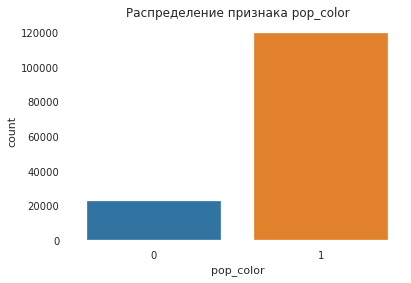

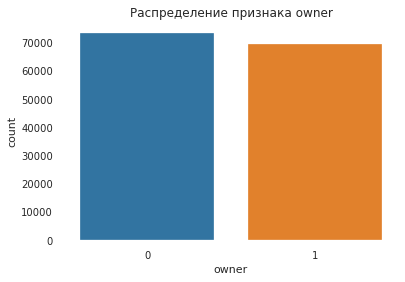

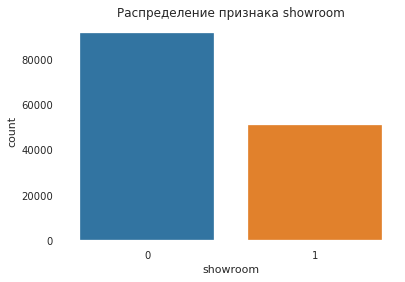

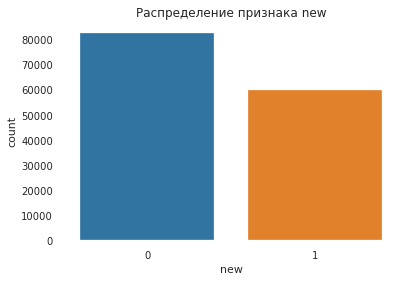

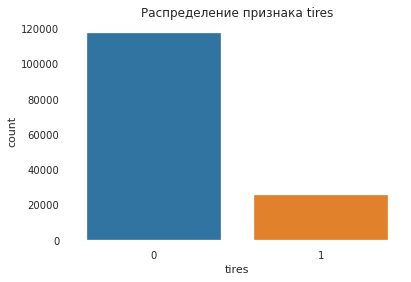

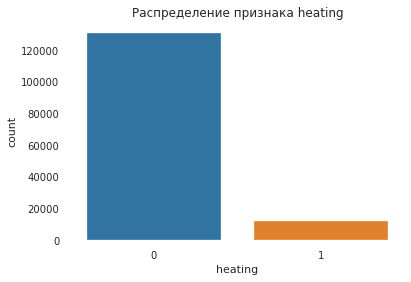

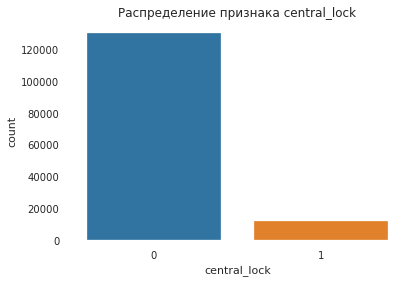

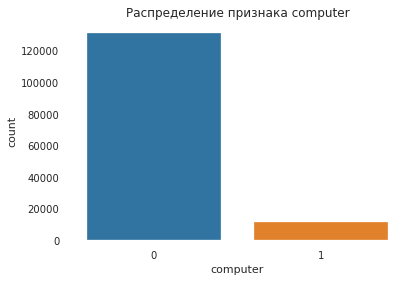

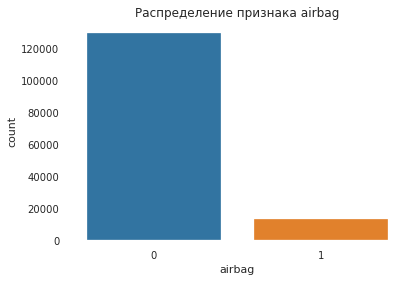

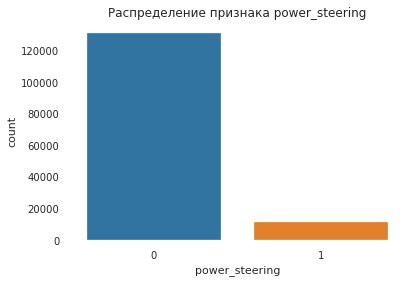

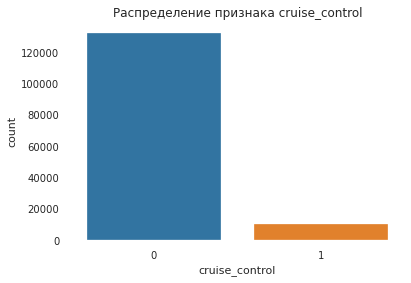

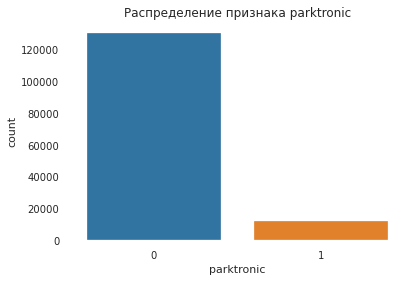

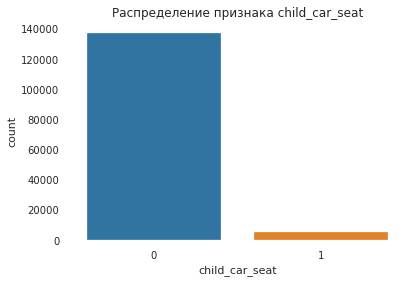

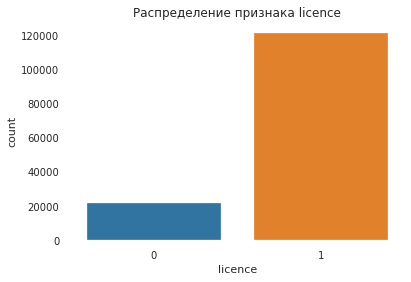

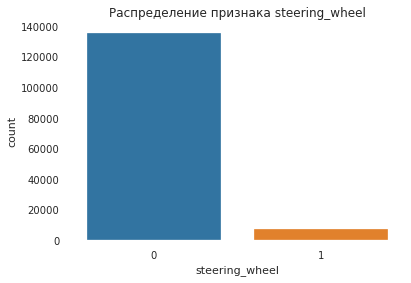

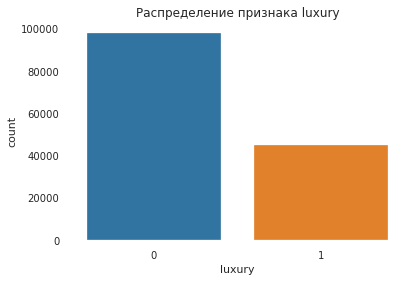

In [126]:
for col in bin_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

Казалось бы, некоторые признаки с большой разницей между 0 и 1 можно удалить. Но сначала давайте посмотрим на корреляции и на значимость.

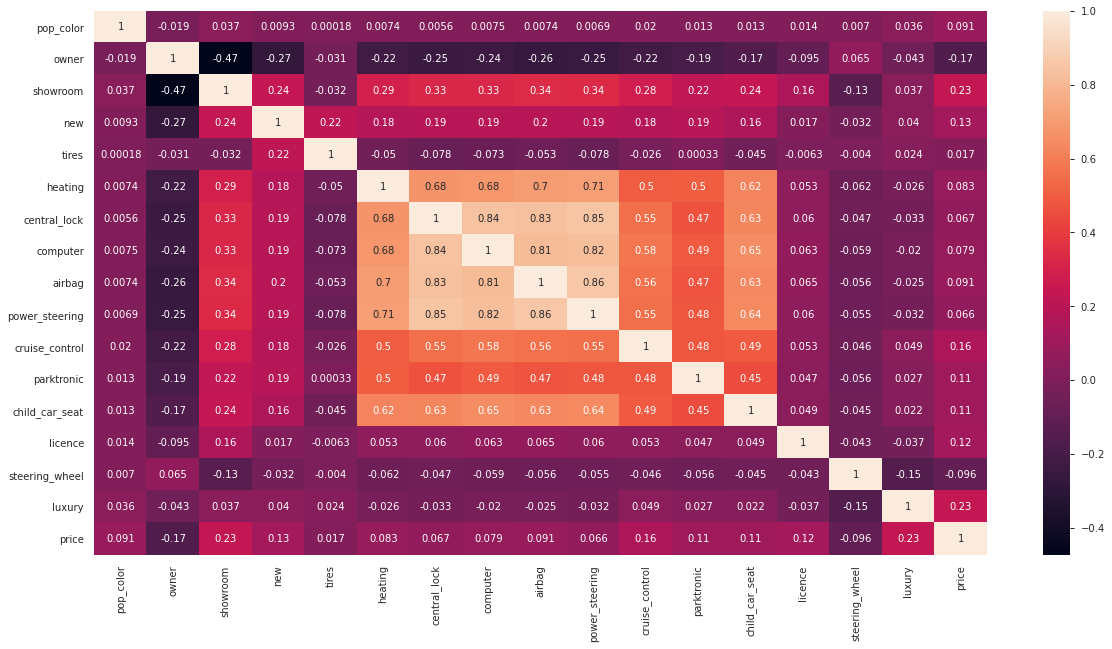

In [127]:
plt.figure(figsize=(20, 10))
sns.heatmap(df[bin_cols+['price']].corr(), annot=True)

Text(0.5, 1.0, 'Значимость бинарных признаков')

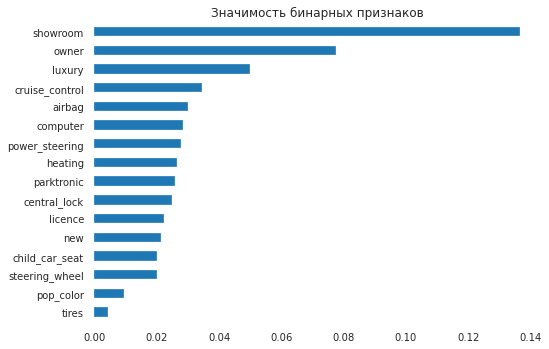

In [128]:
# Значимость бинарных признаков

from sklearn.feature_selection import mutual_info_regression

imp_bin = Series(mutual_info_regression(df[bin_cols], df['price'],
                                        discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

После исследования мы видим, что все признаки мало коррелируют и все более или менее значимы для модели. Оставим все (удаление портит результат, я проверила).

# Числовые признаки

In [129]:
for i in num_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце description_len 0 пропущенных значений
В столбце engine_power 0 пропущенных значений
В столбце mileage 0 пропущенных значений
В столбце production_date 0 пропущенных значений
В столбце model_date 0 пропущенных значений
В столбце model_age 0 пропущенных значений
В столбце prod_age 0 пропущенных значений
В столбце brand_price 0 пропущенных значений
В столбце model_name_price 0 пропущенных значений
В столбце body_type_price 0 пропущенных значений
В столбце engine_volume_price 0 пропущенных значений
В столбце engine_power_price 0 пропущенных значений
В столбце km_year 0 пропущенных значений


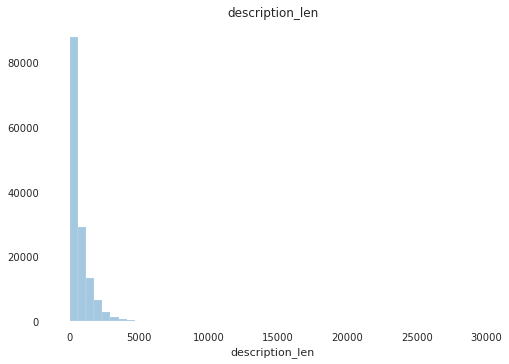

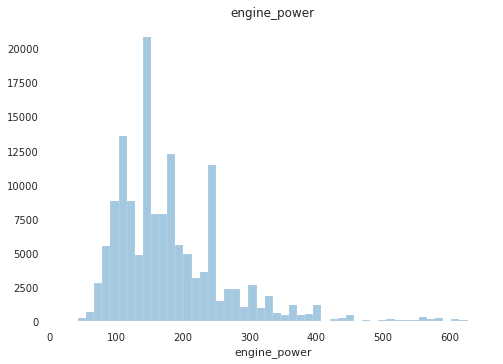

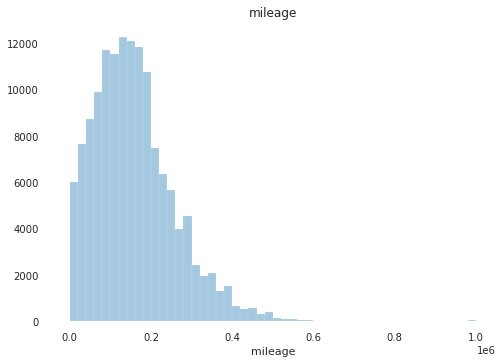

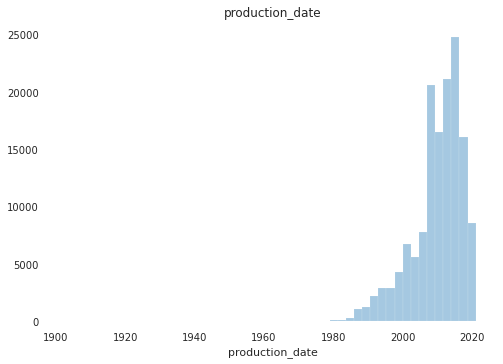

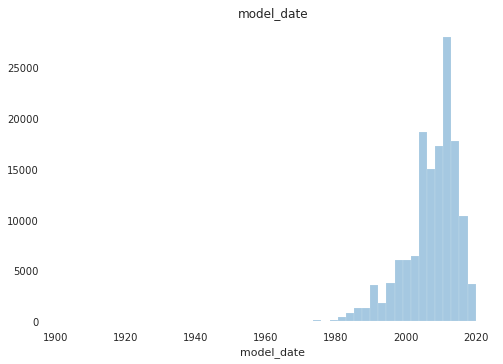

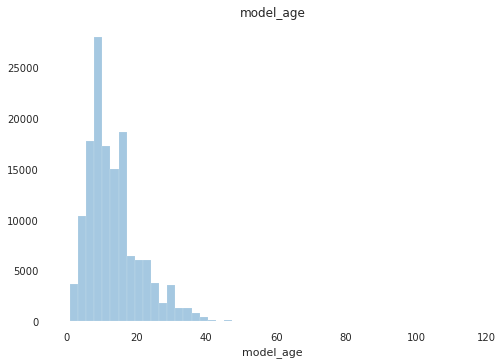

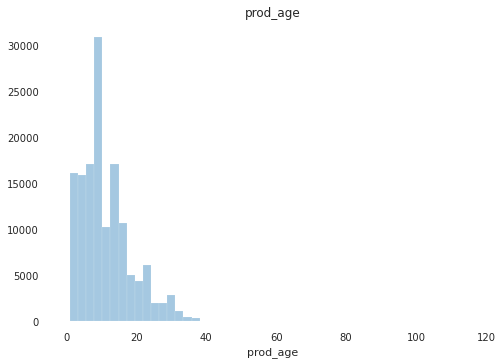

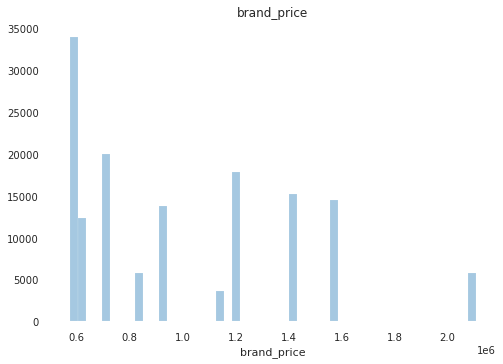

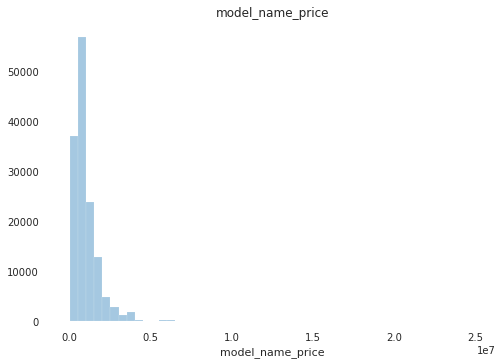

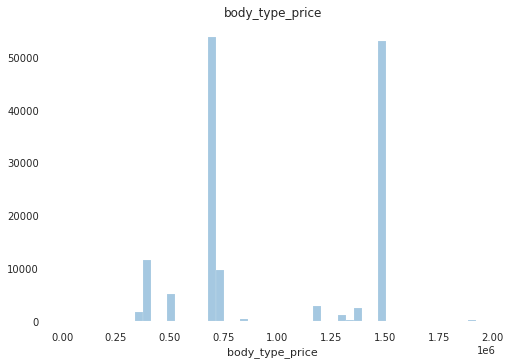

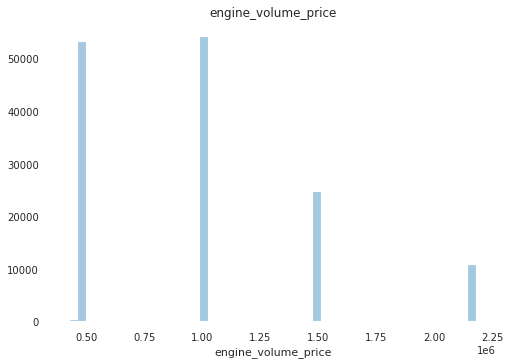

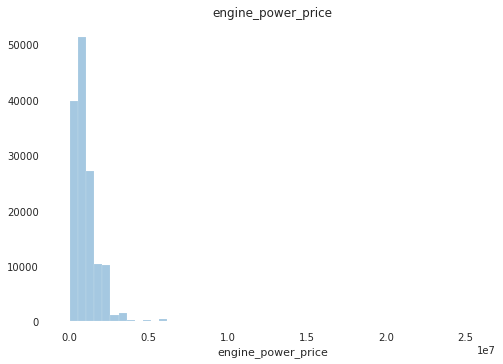

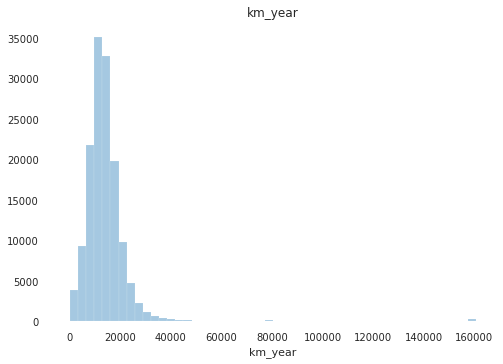

In [130]:
# Поглядим на распределение числовых признаков:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

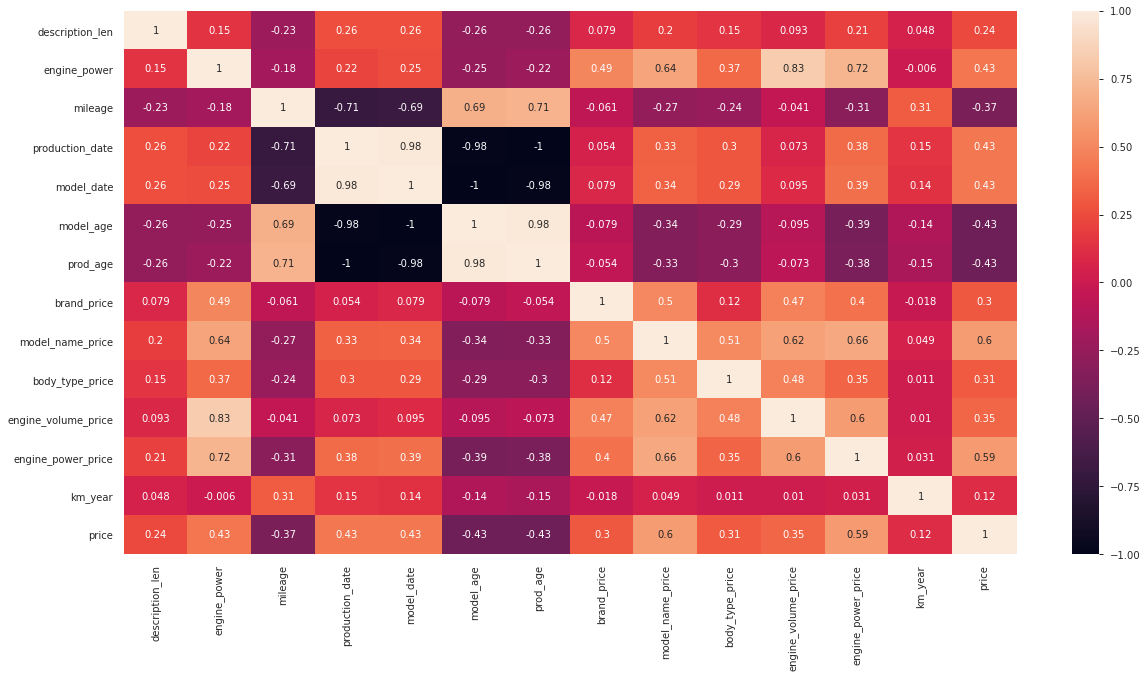

In [131]:
plt.figure(figsize=(20, 10))
sns.heatmap(df[num_cols+['price']].corr(), annot=True)

Несмотря на то, что некоторые признаки сильно коррелируют друг с другом (дата выпуска модели и дата производства машины, возраст модели и машины), их удаление влечет за собой сильное ухудшение модели.

Text(0.5, 1.0, 'Значимость числовых признаков')

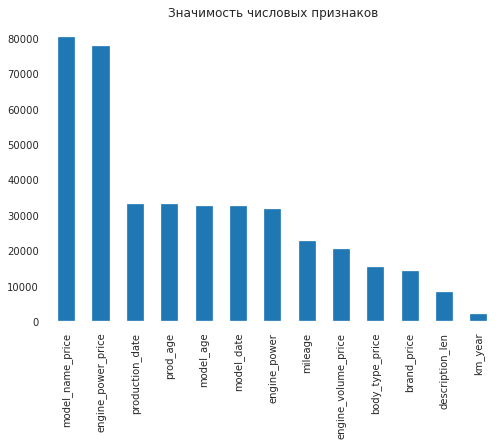

In [132]:
# Используем дисперсионный анализ для определения значимости числовых признаков:
from sklearn.feature_selection import f_regression

imp_num = pd.Series(f_regression(df[num_cols], df["price"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

Кажется, здесь нам тоже нечего удалять.

# Категориальные признаки

In [133]:
for i in cat_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце body_type 0 пропущенных значений
В столбце brand 0 пропущенных значений
В столбце color 0 пропущенных значений
В столбце fuel_type 0 пропущенных значений
В столбце engine_volume 0 пропущенных значений
В столбце transmission 0 пропущенных значений
В столбце type_of_drive 0 пропущенных значений
В столбце model_name 0 пропущенных значений
В столбце owners_qty 1 пропущенных значений
В столбце vehicle_configuration 0 пропущенных значений
В столбце doors 0 пропущенных значений


Поскольку значений для признаков у нас очень много, удобнее проводить анализ после того, как мы переведем их в числовую форму.

In [134]:
# Переведем для всех категориальных признаков значения в числа:
for column in cat_cols:
    df[column] = df[column].astype('category').cat.codes

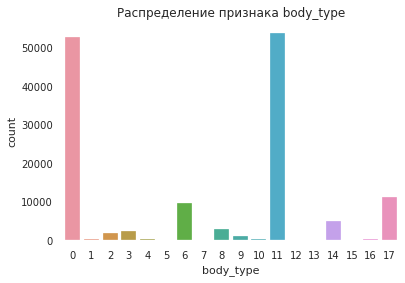

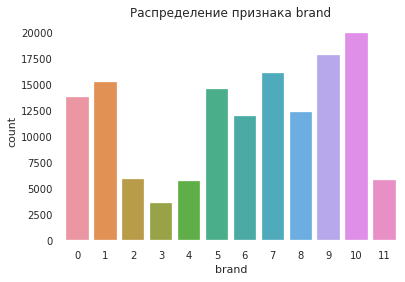

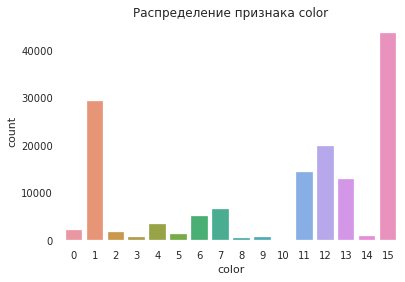

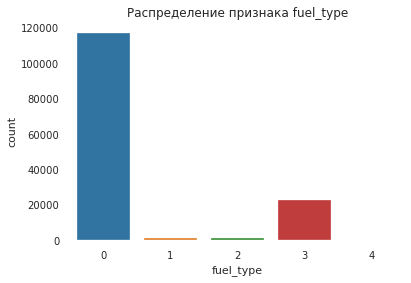

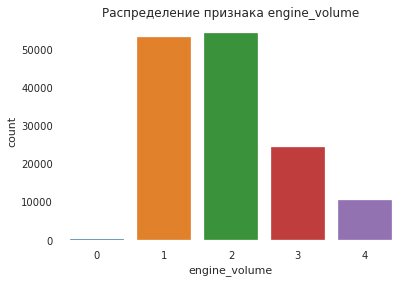

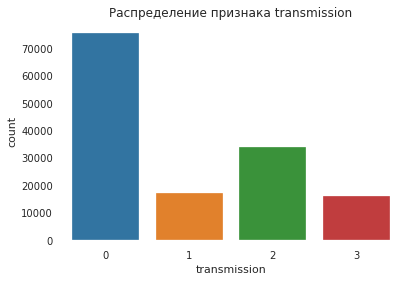

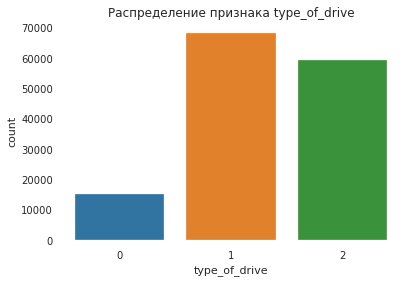

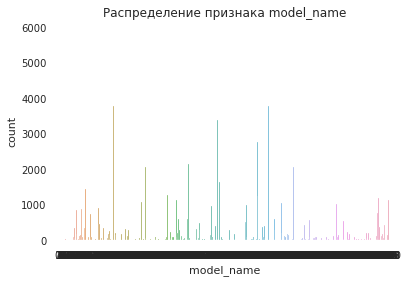

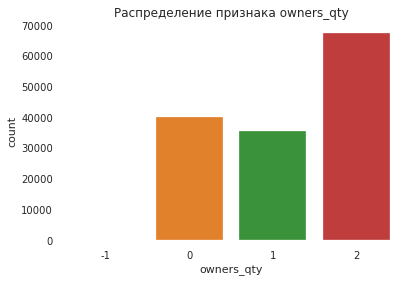

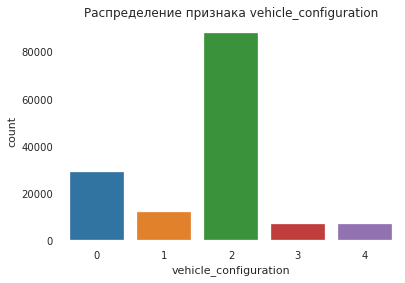

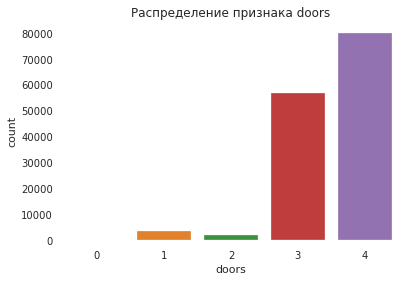

In [135]:
# Построим графики распределения значений по их количеству:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

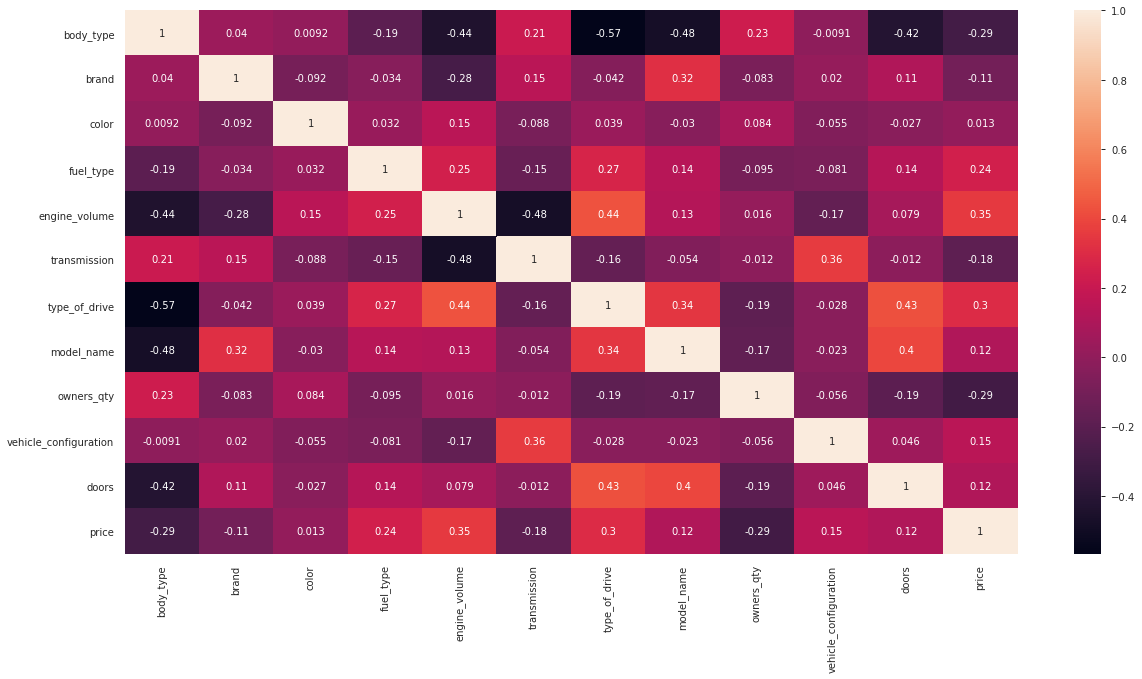

In [136]:
plt.figure(figsize=(20,10))
sns.heatmap(df[cat_cols+['price']].corr(), annot=True)

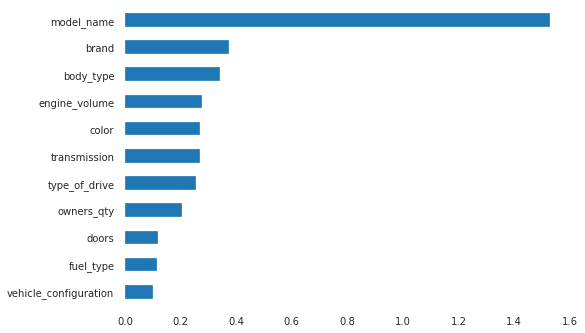

In [137]:
# Проверим значимость категориальных переменных:
from sklearn.feature_selection import mutual_info_classif

temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols],
                                     temp_df['price'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

## Дополнительные признаки

Дополним все числовые признаки категориальными

In [138]:
for col in num_cols:
    df[col + '_' + 'cat'] = 0
    perc25 = df[col].quantile(0.25)
    perc50 = df[col].quantile(0.5)
    perc75 = df[col].quantile(0.75)
    df[col + '_' + 'cat'] = df[col].apply(lambda x: sign_to_cat(x))
    df[col + '_' + 'cat'] = df[col + '_' + 'cat'].astype('category').cat.codes

Можно логарифмировать числовые признаки для нормализации распределения, но от этого результат меняется не слишком сильно.

In [139]:
for i in ['engine_power', 'description_len', 'production_date', 'model_date', 'model_age', 'prod_age',
          'model_name_price', 'engine_volume_price', 'engine_power_price', 'km_year']:
    df[i] = df[i].apply(lambda x: np.log(x+1))

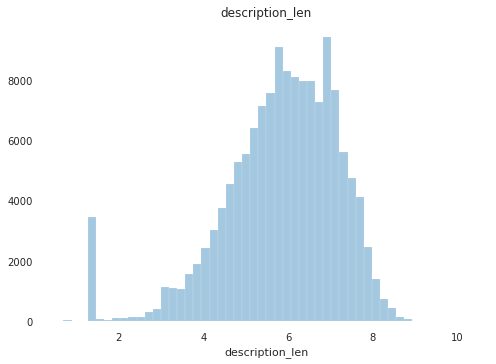

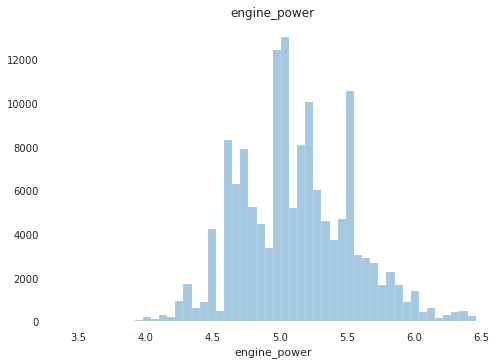

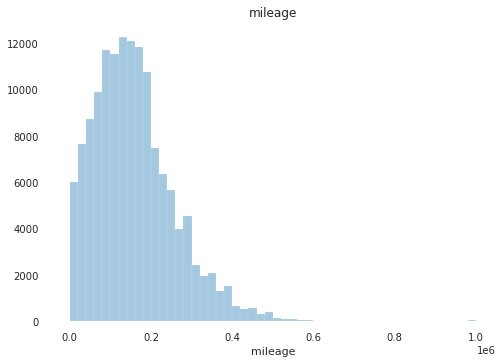

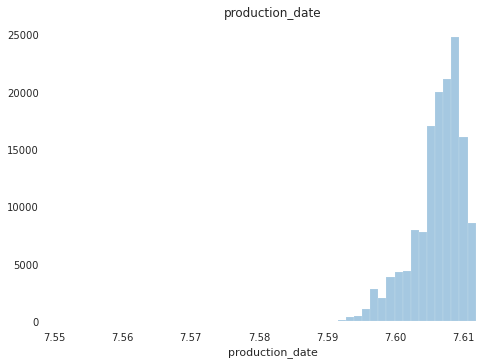

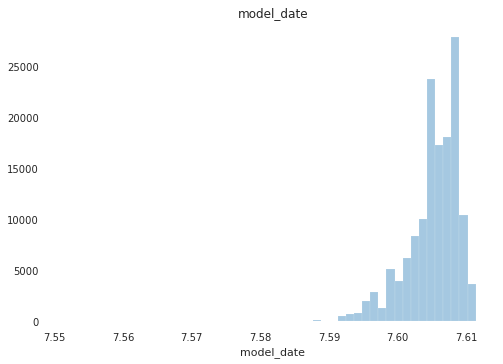

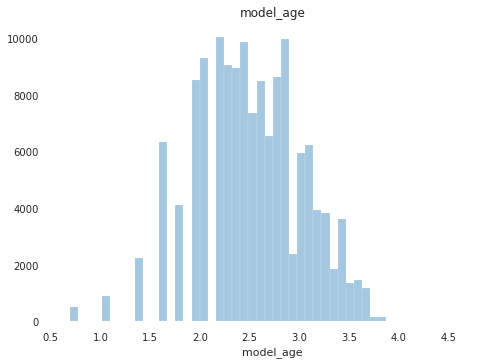

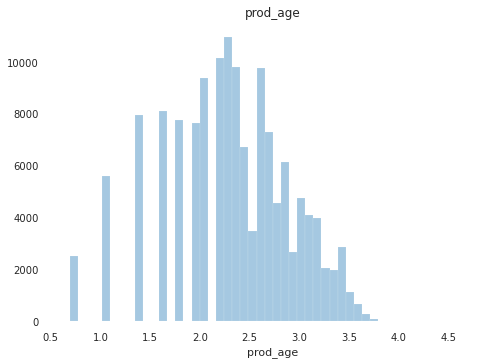

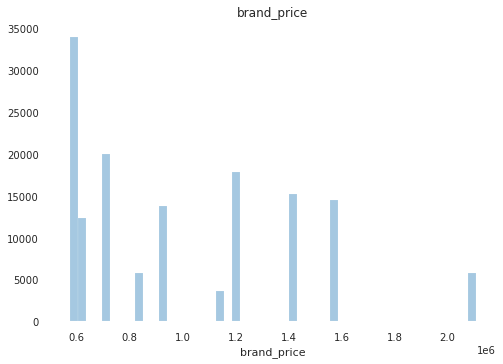

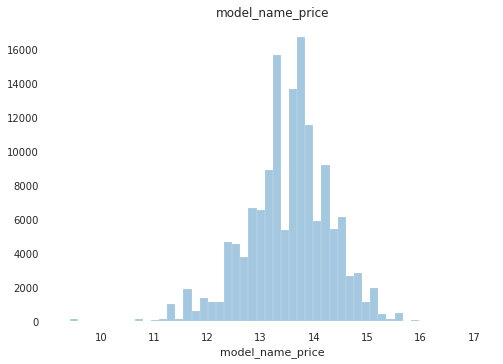

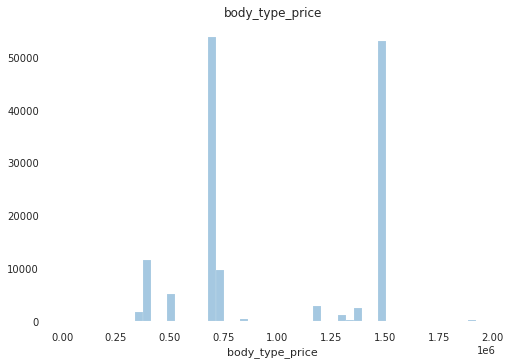

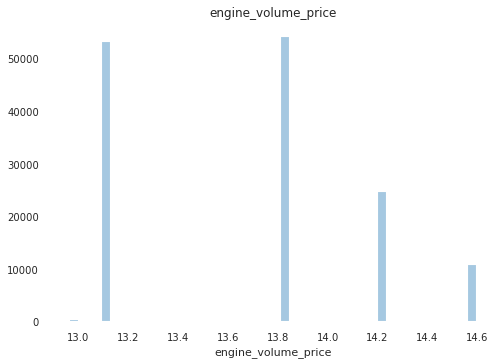

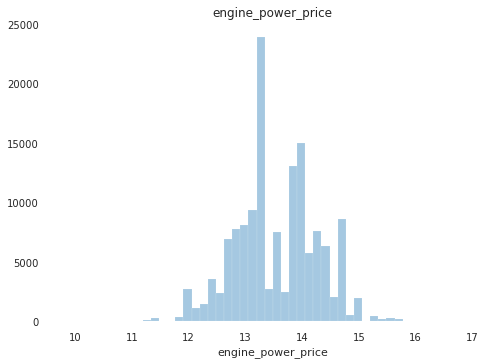

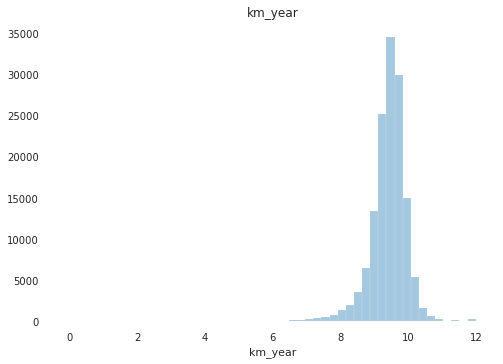

In [140]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [141]:
# Для контроля выведем наш датасет еще раз:
df.head()

,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,price,train,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
0,0,11,13,3,7.608374,598,4,7.609367,0,0,2,5.463832,85452,2,0,1,1,2799000.0,1,1,6.222576,0,1,0,0,0,0,0,0,0,0,0,0,1.791759,2.079442,13.947422,844140.662736,1.503371e+06,13.834725,14.384325,1,9.564021,2,3,0,3,3,0,0,1,2,1,1,3,2
1,11,11,15,0,7.605890,460,3,7.607878,0,0,2,5.521461,116410,1,0,0,1,1277000.0,1,1,7.012115,0,1,0,0,0,0,0,0,0,0,0,0,2.197225,2.564949,13.114751,844140.662736,6.846709e+05,13.834725,14.747753,1,9.467726,3,3,1,2,1,1,1,1,1,0,1,3,1
2,0,11,15,3,7.607878,596,4,7.609367,0,0,2,5.252273,83657,2,0,0,1,1869000.0,1,1,7.102499,0,1,1,0,0,0,0,0,0,0,0,0,1.791759,2.197225,14.142726,844140.662736,1.503371e+06,13.834725,14.352560,1,9.542793,3,2,0,3,2,0,0,1,3,1,1,3,2
3,11,11,15,0,7.603399,454,3,7.604396,0,0,2,5.141664,118000,1,0,2,1,369000.0,1,1,6.914731,0,1,0,0,0,0,0,0,0,0,0,0,2.772589,2.890372,13.177641,844140.662736,6.846709e+05,13.834725,13.321899,1,8.905987,3,2,1,0,0,3,3,1,1,0,1,1,0
4,11,11,1,0,7.606387,454,3,7.607381,3,3,1,5.017280,121421,1,0,2,0,650000.0,1,1,5.318120,1,0,0,0,0,0,0,0,0,0,0,0,2.302585,2.484907,13.177641,844140.662736,6.846709e+05,13.112687,13.772908,1,9.404516,1,1,1,2,2,1,1,1,1,0,0,2,1


Теперь сравним то, с чего мы начинали, с тем, что получили:

In [142]:
display(cars.info())
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142895 entries, 0 to 142894
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            108209 non-null  float64
 1   bodyType              142895 non-null  object 
 2   brand                 142895 non-null  object 
 3   car_url               142895 non-null  object 
 4   color                 142895 non-null  object 
 5   complectation_dict    26583 non-null   object 
 6   description           139484 non-null  object 
 7   engineDisplacement    142895 non-null  object 
 8   enginePower           142895 non-null  object 
 9   equipment_dict        44855 non-null   object 
 10  fuelType              142895 non-null  object 
 11  image                 54851 non-null   object 
 12  mileage               142341 non-null  float64
 13  modelDate             142895 non-null  float64
 14  model_info            54851 non-null   object 
 15  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142895 entries, 0 to 142894
Data columns (total 55 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   body_type                142895 non-null  int8   
 1   brand                    142895 non-null  int8   
 2   color                    142895 non-null  int8   
 3   fuel_type                142895 non-null  int8   
 4   model_date               142895 non-null  float64
 5   model_name               142895 non-null  int16  
 6   doors                    142895 non-null  int8   
 7   production_date          142895 non-null  float64
 8   vehicle_configuration    142895 non-null  int8   
 9   transmission             142895 non-null  int8   
 10  engine_volume            142895 non-null  int8   
 11  engine_power             142895 non-null  float64
 12  mileage                  142895 non-null  int64  
 13  type_of_drive            142895 non-null  int8   
 14  stee

None

Сохраним датасет в csv.

In [143]:
df.to_csv(f'cars_selection_v{VERSION}.csv', index=False)

# Необходимые приготовления к обучению

In [144]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [145]:
# Фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы:
RANDOM_SEED = 42
VAL_SIZE = 0.2

# Разделяем тестовую и тренировочную части

In [146]:
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [147]:
test = test.drop(['price'], axis=1)

In [148]:
X = train.drop(['price'], axis=1)
y = train['price']
X_sub = test

In [149]:
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тестового датасета:  (34686, 53)


,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
108209,6,8,13,0,7.607878,357,4,7.608374,3,3,1,4.663439,74000,1,0,2,1,1,6.909753,0,1,0,0,0,0,0,0,0,0,0,0,2.079442,2.197225,13.228233,614402.703322,732924.219025,13.112687,12.898938,0,9.132487,3,0,0,2,2,0,1,0,1,1,0,0,0
108210,6,8,15,0,7.609862,357,4,7.609862,1,2,1,4.709530,60563,1,0,0,1,1,7.867106,0,1,1,0,0,1,1,1,1,1,0,0,1.609438,1.609438,13.228233,614402.703322,732924.219025,13.112687,13.314507,0,9.402084,3,0,0,3,3,0,0,0,1,1,0,1,1
108211,6,8,12,0,7.607878,509,4,7.608374,3,3,1,5.030438,88000,1,0,0,1,1,6.909753,0,1,0,0,0,0,0,0,0,0,0,0,2.079442,2.197225,13.542593,614402.703322,732924.219025,13.112687,13.194080,0,9.305741,3,1,1,2,2,0,1,0,1,1,0,1,1
108212,6,8,6,0,7.607878,357,4,7.608374,0,0,1,4.709530,95000,1,0,0,1,0,7.424762,1,1,1,0,0,0,0,0,0,0,0,0,2.079442,2.197225,13.228233,614402.703322,732924.219025,13.112687,13.314507,0,9.382275,3,0,1,2,2,0,1,0,1,1,0,1,1
108213,6,8,1,0,7.605392,357,4,7.607381,0,0,1,5.030438,58536,1,0,0,1,1,7.768956,0,1,1,0,0,1,1,1,1,1,0,0,2.302585,2.639057,13.228233,614402.703322,732924.219025,13.112687,13.194080,0,8.674983,3,1,0,2,1,2,1,0,1,1,0,1,0


In [150]:
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))

Размерность тренировочного датасета:  (108209, 54)


,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,price,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
0,0,11,13,3,7.608374,598,4,7.609367,0,0,2,5.463832,85452,2,0,1,1,2799000.0,1,6.222576,0,1,0,0,0,0,0,0,0,0,0,0,1.791759,2.079442,13.947422,844140.662736,1.503371e+06,13.834725,14.384325,1,9.564021,2,3,0,3,3,0,0,1,2,1,1,3,2
1,11,11,15,0,7.605890,460,3,7.607878,0,0,2,5.521461,116410,1,0,0,1,1277000.0,1,7.012115,0,1,0,0,0,0,0,0,0,0,0,0,2.197225,2.564949,13.114751,844140.662736,6.846709e+05,13.834725,14.747753,1,9.467726,3,3,1,2,1,1,1,1,1,0,1,3,1
2,0,11,15,3,7.607878,596,4,7.609367,0,0,2,5.252273,83657,2,0,0,1,1869000.0,1,7.102499,0,1,1,0,0,0,0,0,0,0,0,0,1.791759,2.197225,14.142726,844140.662736,1.503371e+06,13.834725,14.352560,1,9.542793,3,2,0,3,2,0,0,1,3,1,1,3,2
3,11,11,15,0,7.603399,454,3,7.604396,0,0,2,5.141664,118000,1,0,2,1,369000.0,1,6.914731,0,1,0,0,0,0,0,0,0,0,0,0,2.772589,2.890372,13.177641,844140.662736,6.846709e+05,13.834725,13.321899,1,8.905987,3,2,1,0,0,3,3,1,1,0,1,1,0
4,11,11,1,0,7.606387,454,3,7.607381,3,3,1,5.017280,121421,1,0,2,0,650000.0,1,5.318120,1,0,0,0,0,0,0,0,0,0,0,0,2.302585,2.484907,13.177641,844140.662736,6.846709e+05,13.112687,13.772908,1,9.404516,1,1,1,2,2,1,1,1,1,0,0,2,1


In [151]:
print(train.columns, len(train.columns))
print(test.columns, len(test.columns))

Index(['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'model_name',
       'doors', 'production_date', 'vehicle_configuration', 'transmission',
       'engine_volume', 'engine_power', 'mileage', 'type_of_drive',
       'steering_wheel', 'owners_qty', 'licence', 'price', 'pop_color',
       'description_len', 'owner', 'showroom', 'new', 'tires', 'heating',
       'central_lock', 'computer', 'airbag', 'power_steering',
       'cruise_control', 'parktronic', 'child_car_seat', 'prod_age',
       'model_age', 'model_name_price', 'brand_price', 'body_type_price',
       'engine_volume_price', 'engine_power_price', 'luxury', 'km_year',
       'description_len_cat', 'engine_power_cat', 'mileage_cat',
       'production_date_cat', 'model_date_cat', 'model_age_cat',
       'prod_age_cat', 'brand_price_cat', 'model_name_price_cat',
       'body_type_price_cat', 'engine_volume_price_cat',
       'engine_power_price_cat', 'km_year_cat'],
      dtype='object') 54
Index(['body_type', 'bran

## Train Split

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Введем "наивную" модель 
Эта модель опять будет предсказывать среднюю цену по модели двигателя (engine_volume в нашем датасете). 
В базовом решении значение точности модели по метрике MAPE было равно 117.95% Из-за обработки данных (теперь у нас это категориальный признак) результат изменится - посмотрим, как именно.

In [153]:
tmp_train = X_train.copy()

In [154]:
tmp_train['price'] = y_train

In [155]:
# Находим median по экземплярам engine_volume в трейне и размечаем тест
predict = X_test['engine_volume'].map(
    tmp_train.groupby('engine_volume')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 110.59%


А теперь попробуем взять экспоненту от признака. Значение сильно улучшается.

In [156]:
# Находим median по экземплярам engine_volume в трейне и размечаем тест
predict = np.exp(X_test['engine_volume']).map(
    tmp_train.groupby('engine_volume')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 60.97%


# # CatBoost

У нас в данных много категориальных данных Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://) Попробуем применить ее. 

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [157]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

In [158]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 13.52%


Со старта, даже не трогая сами данные и не подбирая настройки catboosta, мы получили модель с уровнем ошибки в 18%! После преобразования данных и внедрения новых признаков точность достигла 13.5%.

### Log Traget
Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [159]:
np.log(y_train)

106941    11.982929
80643     13.161584
77887     14.900362
24969     14.448377
82218     13.342623
            ...    
54886     15.222471
76820     13.493927
103694    12.144197
860       14.790070
15795     14.383095
Name: price, Length: 86567, dtype: float64

In [160]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

In [161]:
predict_test =  np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [162]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.21%


Точность модели значительно повысилась и составляет теперь 12.14%, если не переводить числовые данные в категориальные. И чуть повышается, если переводить (12.21).

In [163]:
# X_train_norm = StandardScaler().fit_transform(X_train)
# X_test_norm = StandardScaler().fit_transform(X_test)

# Простая линейная регрессия

In [164]:
lin_reg = LinearRegression().fit(X_train, np.log(y_train))
y_pred = lin_reg.predict(X_test)

In [165]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(y_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 19.88%


Это не слишком годная модель для подобного исследования: всего 20.4%, если не переводить числовые данные в категориальные. При дополнении числовых признаков такими же, но категориальными, точность становится лучше (19.88). Если заменять числовые категориальными - хуже.


# Gradient Boosting

In [166]:
gb = GradientBoostingRegressor(min_samples_split=2, 
                               learning_rate=0.03, 
                               max_depth=10, 
                               n_estimators=1000)

In [167]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000)

In [168]:
y_pred = gb.predict(X_test)

In [169]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.38%


Очень долго работает даже без подбора параметров

Точность модели по метрике MAPE: 13.39%

С подбором параметров работает еще дольше, закомментируем. Результат отдельного запуска приведем ниже.

In [170]:
def regularise(X_train, y_train):
    max_depth = [5, 10, 15]
    n_estimators = [100, 200, 1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [171]:
# best_max_depth, best_n_estimators = regularise(X_train, y_train)
# best_max_depth, best_n_estimators

In [172]:
# gb_best = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)


In [173]:
# gb_best.fit(X_train, np.log(y_train+1))


In [174]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb_best.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE - 12.99%

# Random Forest

In [175]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [176]:
rf = RandomForestRegressor(n_estimators=1000,
                           n_jobs=-1,
                           max_depth=15,
                           max_features='log2',
                           random_state=RANDOM_SEED,
                           oob_score=True)

In [177]:
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)

In [178]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 14.60%. Закомментировано, так как очень долго обучается.

In [179]:
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=5,
                                 min_samples_leaf=1, max_features='auto', max_depth=15, bootstrap=True)

# best_rfr.fit(X_train, np.log(y_train))

# predict_rfr = np.exp(best_rfr.predict(X_test))

In [180]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE: 12.96%

# Stacking

In [181]:
from sklearn.ensemble import StackingRegressor

In [182]:
estimators = [('cb', CatBoostRegressor(iterations=5000,
                                       random_seed=RANDOM_SEED,
                                       eval_metric='MAPE',
                                       custom_metric=['R2', 'MAE'],
                                       silent=True)),
              ('rf', RandomForestRegressor(n_estimators=1000,
                                           n_jobs=-1,
                                           max_depth=15,
                                           max_features='log2',
                                           random_state=RANDOM_SEED,
                                           oob_score=True))]


st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                    min_samples_split=2,
                                    learning_rate=0.03,
                                    max_depth=10,
                                    n_estimators=1000))


st_ensemble.fit(X_train, np.log(y_train))

StackingRegressor(estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x7fdc915f6290>),
                              ('rf',
                               RandomForestRegressor(max_depth=15,
                                                     max_features='log2',
                                                     n_estimators=1000,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=42))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.03,
                                                            max_depth=10,
                                                            n_estimators=1000))

In [183]:
y_pred = np.exp(st_ensemble.predict(X_test))

In [184]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.63%


Точность модели по метрике MAPE: 12.63%

# Другой вариант стекинга

In [185]:
'''
from sklearn.base import clone

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


y_train = y_train
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)

    return X_meta_train, X_meta_test


def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(
        regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]
    stacked_features_train = np.vstack(
        [features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack(
        [features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test


X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)
'''

'\nfrom sklearn.base import clone\n\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n\ny_train = y_train\ny_test = y_test\n\ncv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)\n\n\ndef compute_meta_feature(regr, X_train, X_test, y_train, cv):\n    X_meta_train = np.zeros_like(y_train, dtype=np.float32)\n    splits = cv.split(X_train)\n    for train_fold_index, predict_fold_index in splits:\n        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]\n        y_fold_train = y_train[train_fold_index]\n\n        folded_regr = clone(regr)\n        folded_regr.fit(X_fold_train, y_fold_train)\n\n        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)\n\n    meta_regr = clone(regr)\n    meta_regr.fit(X_train, y_train)\n\n    X_meta_test = meta_regr.predict(X_test)\n\n    return X_meta_train, X_meta_test\n\n\ndef generate_meta_features(regr, X_train, X_test, y_train, cv

In [186]:
'''
from sklearn.neighbors import KNeighborsRegressor

regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
    regr,
    GradientBoostingRegressor(
        min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
    KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree',
                        weights='distance', p=1),
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                          verbose=1, max_depth=5, n_estimators=200),
    ExtraTreesRegressor(random_state=RANDOM_SEED),
    RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15)
], X_train, X_test, y_train, cv)
'''

"\nfrom sklearn.neighbors import KNeighborsRegressor\n\nregr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,\n                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)\n\nstacked_features_train, stacked_features_test = generate_meta_features([\n    regr,\n    GradientBoostingRegressor(\n        min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),\n    KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree',\n                        weights='distance', p=1),\n    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,\n                          verbose=1, max_depth=5, n_estimators=200),\n    ExtraTreesRegressor(random_state=RANDOM_SEED),\n    RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15)\n], X_train, X_test, y_train, cv)\n"

In [187]:
'''
def compute_metric(regr, X_train, y_train, X_test, y_test):
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    return np.round(mape(y_test, y_test_pred)*100, 2)


VERSION = 9
print(
    f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")
'''

'\ndef compute_metric(regr, X_train, y_train, X_test, y_test):\n    regr.fit(X_train, y_train)\n    y_test_pred = regr.predict(X_test)\n    return np.round(mape(y_test, y_test_pred)*100, 2)\n\n\nVERSION = 9\nprint(\n    f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")\n'

Точность модели по метрике MAPE: 13.45%

# XGB Regressor - лучший вариант!

In [188]:
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03,
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)

In [189]:
xb.fit(X_train, np.log(y_train))

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [190]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 12.06%


Лучший результат (11.98%) был достигнут, когда числовые признаки мы не дополняли одноименными категориальными и не логарифмировали. Но при сабмите в соревнование описанный подход незначительно улучшает результат (12.67605).
Худший из последних результатов (12.32%) - если числовые признаки заменяли на категориальные. При таком подходе и результат сабмита сильно портился (до 13.15%).

Вариант на последнем изменении данных - 12.06%

In [191]:
# xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03,
#                      max_depth=15, alpha=1, n_jobs=-1, n_estimators=1000)

In [192]:
# xb.fit(X_train, np.log(y_train))

In [193]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")

Тут игра с параметрами. При увеличении learning_rate точность ухудшается (12.67% при 0.15). Если при этом уменьшить максимальную глубину до 10, то ошибка станет меньше (12.57). При параметрах learning_rate=0.03, max_depth=10 точность несущественно уменьшается по сравнению с эталоном (12.08%).

# LightGBM

Говорят, что это одно из самых быстрых и мощных средств обучения. Но для нашей задачи оно показывает менее хороший результат, зато сравнительно быстро.

In [194]:
import lightgbm as lgb

In [195]:
model_LGBM = lgb.LGBMRegressor(n_estimators=2000)
model_LGBM.fit(X_train, np.log(y_train))

y_pred = np.exp(model_LGBM.predict(X_test))

In [196]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.37%


Точность модели по метрике MAPE: от 12.44% до 12.37% при небольшой разнице в данных.

# Bagging

C LightGBM

In [197]:
from sklearn.ensemble import BaggingRegressor
bagg_LGBM = BaggingRegressor(
    model_LGBM, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_LGBM.fit(X_train, np.log(y_train))
y_pred = np.exp(bagg_LGBM.predict(X_test))

In [198]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.34%


Точность модели по метрике MAPE: 12.34%

C XGB

In [199]:
bagg_XGB = BaggingRegressor(
    xb, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_XGB.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_XGB.predict(X_test))

In [200]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

Точность модели по метрике MAPE: 12.11%


Точность модели по метрике MAPE: 12.11%

# Выводы:

Проведя несколько экспериментов, мы убедились, что для нашей задачи наилучшим образом подходит XGBoost, который считается одной из самых популярных и эффективных реализаций алгоритма градиентного бустинга на деревьях на 2019-й год.

В основе XGBoost лежит алгоритм градиентного бустинга деревьев решений. Обучение ансамбля проводится последовательно — в отличие, например от бэггинга. На каждой итерации вычисляются отклонения предсказаний уже обученного ансамбля на обучающей выборке. Следующая модель, которая будет добавлена в ансамбль, будет предсказывать эти отклонения. Таким образом, добавив предсказания нового дерева к предсказаниям обученного ансамбля, мы можем уменьшить среднее отклонение модели, которое является таргетом оптимизационной задачи. Новые деревья добавляются в ансамбль до тех пор, пока ошибка уменьшается, либо пока не выполняется одно из правил "ранней остановки".

Подробнее см. [документацию](https://xgboost.readthedocs.io/en/latest/parameter.html)


In [201]:
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.round(np.exp(xb.predict(X_sub)))

# Submission

In [202]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,648398.0
1,1100549428,1065608.0
2,1100658222,908516.0
3,1100937408,804771.0
4,1101037972,796198.0
5,1100912634,731667.0
6,1101228730,668343.0
7,1100165896,387891.0
8,1100768262,2008465.0
9,1101218501,822674.0


В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки (например, логарифмировать не все числовые признаки, а в разных сочетаниях)
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать другие ансамбли моделей, Blending, Stacking с другими моделями.

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing